## setup

In [4]:
import sys
print(sys.version_info)
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn
print ("Scikit-Learn version: ", sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Where to save the figures
from pathlib import Path

# 각자 알맞은 path를 지정(필수는 아님)
IMAGES_PATH = Path() / "training" / "NN"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


sys.version_info(major=3, minor=11, micro=4, releaselevel='final', serial=0)
Scikit-Learn version:  1.3.0


## data preparation

In [5]:
from pathlib import Path
print(IMAGES_PATH)

training\NN


In [6]:
from sklearn.datasets import fetch_openml

openml = fetch_openml('mnist_784', as_frame=False, parser="auto")
mnist = openml

C:\Users\museo\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [7]:
# 먼저 mnist dataset을 가지고 진행함
X_mnist, y_mnist = mnist.data, mnist.target
print(X_mnist.shape, y_mnist.shape)

(70000, 784) (70000,)


In [13]:
def split_dataset(X,y,train_ratio=0.6, vali_ratio=0.2, test_ratio=0.2, random = 42):
    from sklearn.model_selection import train_test_split
    
    # use train_test_split twice to split into 3(train, test, validation)
    X_train, X_remain, y_train, y_remain = train_test_split(X, y, train_size=train_ratio, random_state=random)
    X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=vali_ratio/(vali_ratio+test_ratio), random_state=random)
    
    return X_train,y_train,X_val,y_val,X_test,y_test

# dataset을 3:1:1의 train validation test로 분할
X_mnist_train,y_mnist_train,X_mnist_val,y_mnist_val,X_mnist_test,y_mnist_test = split_dataset(X_mnist, y_mnist)

In [14]:
print(X_mnist_train.shape,X_mnist_val.shape,X_mnist_test.shape)

(42000, 784) (14000, 784) (14000, 784)


In [15]:
from sklearn.neural_network import MLPClassifier

random = 42

# 먼저 random_state을 제외한 모든 hyperparameter를 default를 둔 채 fit
nn_clf = MLPClassifier(random_state=random).fit(X_mnist_train, y_mnist_train)

In [20]:
nn_clf.score(X_mnist_val, y_mnist_val)

0.9614285714285714

In [32]:
pred = np.asarray(nn_clf.predict(X_mnist_val))

from sklearn.metrics import multilabel_confusion_matrix
cm = multilabel_confusion_matrix(y_mnist_val, pred,labels=nn_clf.classes_)
cm

array([[[12612,    29],
        [   43,  1316]],

       [[12423,    25],
        [   35,  1517]],

       [[12544,    53],
        [   39,  1364]],

       [[12530,    78],
        [   52,  1340]],

       [[12631,    47],
        [   58,  1264]],

       [[12654,    51],
        [   85,  1210]],

       [[12523,    62],
        [   21,  1394]],

       [[12468,    35],
        [   62,  1435]],

       [[12569,    85],
        [   72,  1274]],

       [[12506,    75],
        [   73,  1346]]], dtype=int64)

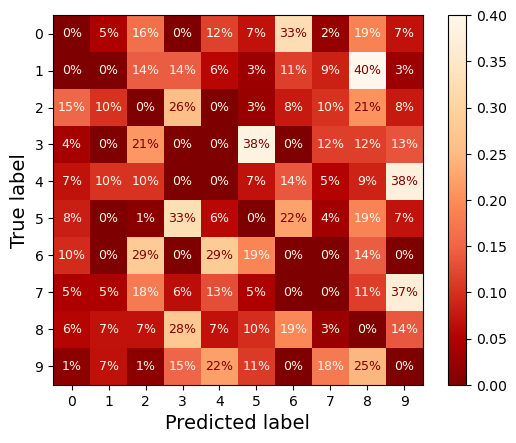

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.rc('font',size=9)
ConfusionMatrixDisplay.from_predictions(y_mnist_val, pred,sample_weight=(y_mnist_val != pred),normalize="true",values_format=".0%",cmap="OrRd_r")
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    nn_clf, X_mnist, y_mnist,n_jobs=-1)
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
plt.show()

In [ ]:

# 더 좋은 hyperparameter를 찾기 위해 gridsearch를 사용

from sklearn.model_selection import GridSearchCV

param_grid = []

grid_search = GridSearchCV(nn_clf)